​
## __Essential Questions :__

- What are some trends in the movie industry?
    - Did movie become more/less popular?
    - Is movie getting less profitable?
    
    - How does the budget of a movie affect the success of the movie and its rating?
    - Which genres are the most profitable/popular?
    - How many forign films were released in US and which countries are they from?
    - Does a director's experience affect the success of a movie?
    - How much do director and main actor matter for the success of a movie?

***

### Dataset: Movie Industry (Version 2) dataset from Kaggle (scrapped from IMDb). 

### Attributes:

    budget: the budget of a movie. Some movies don't have this, so it appears as 0
    company: the production company
    country: country of origin
    director: the director
    genre: main genre of the movie.
    gross: revenue of the movie
    name: name of the movie
    rating: rating of the movie (R, PG, etc.)
    released: release date (YYYY-MM-DD)
    runtime: duration of the movie
    score: IMDb user rating
    votes: number of user votes
    star: main actor/actress
    writer: writer of the movie
    year: year of release

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
plt.style.use('seaborn')
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize']=(12,8)

from bokeh.plotting import figure, output_file, show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker, LogTicker, ContinuousTicker, AdaptiveTicker,
    PrintfTickFormatter,
    ColorBar,
    FactorRange
)
import bokeh.palettes
from bokeh.transform import factor_cmap
from wordcloud import WordCloud, STOPWORDS
from math import floor
from bokeh.io import output_notebook
from bokeh.models import NumeralTickFormatter
from bokeh.resources import CDN
from bokeh.resources import INLINE
from bokeh.embed import file_html
import bokeh.io
bokeh.io.output_notebook(INLINE)

Loading BokehJS ...

## Data Cleaning

In [5]:
df = pd.read_csv('movies.csv')
# checking data types
df.dtypes
# inflation.dtypes

# data types look fine for all the columns

name         object
rating       object
genre        object
year          int64
released     object
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object

In [4]:
# adjusting budget and revenue for inflation

# Still need to find an accurate inflation data

# i = 0
# while(i < len(df)):
#     if(df.loc[i,'year'] < 2021):
#         df.loc[i,'budget'] = inflation.loc[df.loc[i, 'year'], 'index']
#     i = i+1

In [6]:
# checking for missing data
df.isnull().sum()

name           0
rating        77
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         3
star           1
country        3
budget      2171
gross        189
company       17
runtime        4
dtype: int64

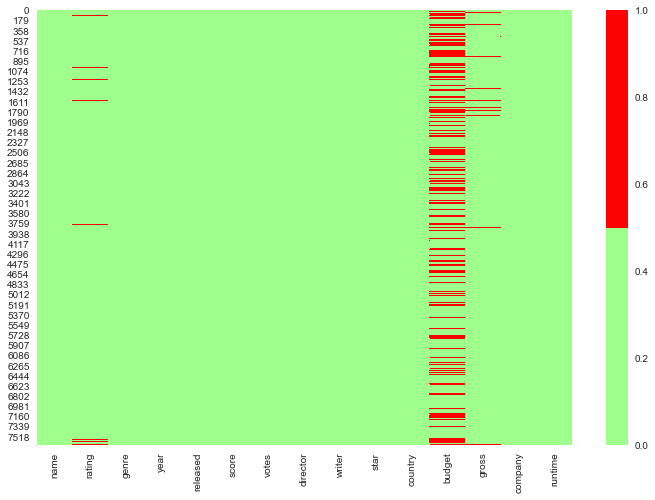

In [7]:
# Visualizing missing data
cols = df.columns[:]
colours = ['#9fff8c', '#fc0303'] # Red is missing. green is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
# Lots of missing data is visible for budget colomn and a little for rating and gross

I used heatmaps to visualize missing values in the dataset for data cleaning

In [8]:
# Missing data percentage
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

name - 0.0%
rating - 1.0%
genre - 0.0%
year - 0.0%
released - 0.0%
score - 0.0%
votes - 0.0%
director - 0.0%
writer - 0.0%
star - 0.0%
country - 0.0%
budget - 28.0%
gross - 2.0%
company - 0.0%
runtime - 0.0%


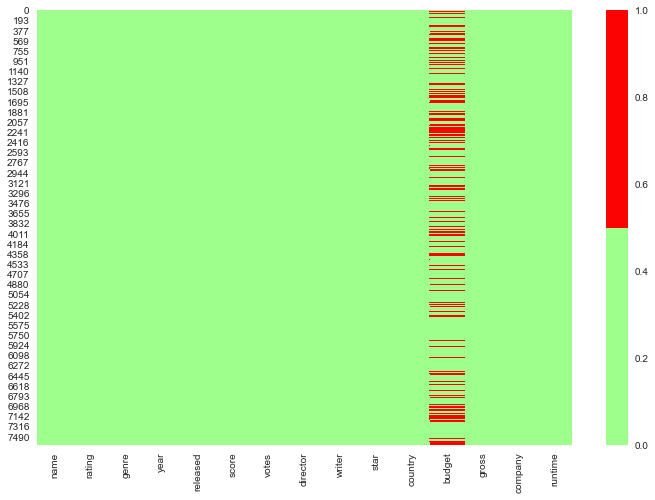

In [9]:
# For rating and gross, the amount of data missing isn't too high (1% and 2% respectively)
# There by, delete all the rows with missing rating and/or gross
# Also remove very little amount of missing rows in other columns except for budget
df_less_missing = df.dropna(subset=['name', 'rating', 'genre', 'year', 'released', 'score', 'votes',
       'director', 'writer', 'star', 'country', 'gross', 'company',
       'runtime'])
# Keep missing values in budget for now, since it's quite a lot (28%)

# double checking with visualizing new data frame
cols = df_less_missing.columns[:]
colours = ['#9fff8c', '#fc0303'] # Red is missing. green is not missing.
sns.heatmap(df_less_missing[cols].isnull(), cmap=sns.color_palette(colours))

In [10]:
# For Budget vs gross comparison later, prepare a dataframe with
# missing rows removed for budget
df_no_missing = df_less_missing.dropna(subset=['budget'])

In [11]:
# checking for duplicates
sum(df.duplicated())
# No duplicate confirmed

0

***

## Data Visualization
***

### Budget vs Success

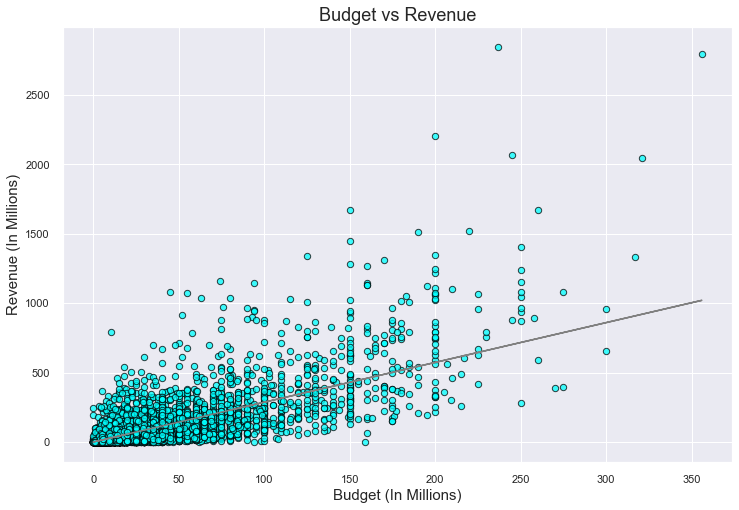

In [35]:
# budget vs Revenue (gross)

plt.scatter(df_no_missing['budget']/1000000, df_no_missing['gross']/1000000, s=40, c='cyan',
            edgecolor='black', linewidth=1, alpha=0.75)
# plt.xscale('log')
# plt.yscale('log')
plt.title('Budget vs Revenue', fontsize=18)
plt.xlabel('Budget (In Millions)', fontsize=15)
plt.ylabel('Revenue (In Millions)', fontsize=15)
# best fit line
m = df_no_missing['gross'].mean()/df_no_missing['budget'].mean()
b = df_no_missing['gross'].mean() - (m*df_no_missing['budget'].mean())
plt.plot(df_no_missing['budget']/1000000, m*df_no_missing['budget']/1000000 + b/1000000, c='grey')

# also can use seaborn
# sns.regplot('budget', 'gross', data=df_no_missing, scatter_kws={'color':'blue'},
#            line_kws={'color':'black'})
# plt.title('Budget vs Revenue', fontsize=18)
# plt.xlabel('Budget (In Millions)', fontsize=15)
# plt.ylabel('Revenue (In Millions)', fontsize=15)

The graph above shows the positive correlation between budget and revenue of movies.
Generally, movies with bigger budget made more revenue

Now, lets check out if the budget of a movie affects its audiences' experience (rating).

[Text(0, 0, '$0'),
 Text(0, 0, '$50,000,000'),
 Text(0, 0, '$100,000,000'),
 Text(0, 0, '$150,000,000'),
 Text(0, 0, '$200,000,000'),
 Text(0, 0, '$250,000,000'),
 Text(0, 0, '$300,000,000'),
 Text(0, 0, '$350,000,000'),
 Text(0, 0, '$400,000,000')]

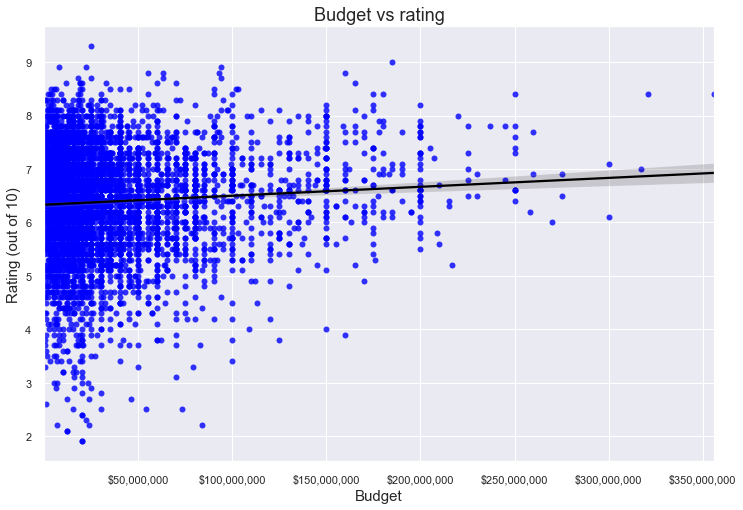

In [13]:
sns.set()
g = sns.regplot('budget', 'score', data=df_no_missing, scatter_kws={'color':'blue'},
           line_kws={'color':'black'})
plt.title('Budget vs rating', fontsize=18)
plt.xlabel('Budget', fontsize=15)
plt.ylabel('Rating (out of 10)', fontsize=15)

ticks = g.get_xticks()
xlabel = ['$' + '{:,.0f}'.format(x) for x in ticks]
g.set_xticklabels(xlabel)

The graph shows that the ratings of movies got only slightly better as the budget increased; the positive correlation appears to quite weak (regression line looks nearly flat). Based on this graph, it's possible to presume that just spending more money won't make a good movie.

### Genre vs Success
Genre of a movie could affect its success depending on what genre is trending
***

First, lets compare the number of movies created in each genre using a pie chart

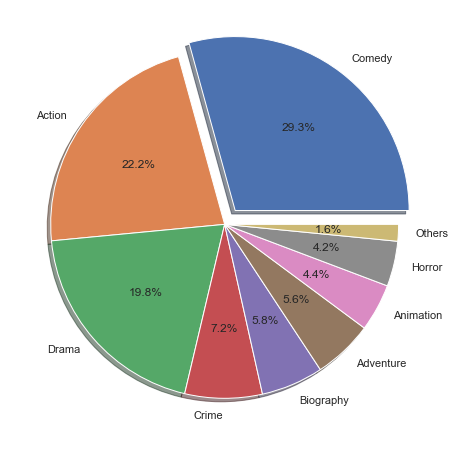

In [14]:
# sort out genre by movie counts
genre = df.groupby(['genre']).size().sort_values(ascending=False).reset_index()
genre.columns = ['genre', 'count']

# group last 10 genres as 'others' since they each only has less than 50 counts.
others = genre.loc[list(range(8,19))]['count'].sum()
genre = genre.drop(list(range(8,19)))
genre.loc[8] = ['Others', others]

labels = genre['genre']
size = genre['count']
plt.pie(size, labels = labels, explode = [.1,0,0,0,0,0,0,0,0], autopct='%1.1f%%', shadow = True)
plt.show()

Next, lets compare each movie genre's average profit over time (1980~2020); the interactive graph was created using 'Bokeh' library.

In [15]:
# Analyzing movie's genre VS success (gross-budget)
# + Movie market size over time by genre
# line graph
df_no_missing['net'] = df_no_missing['gross'] - df_no_missing['budget']

<ipython-input-15-386040a2b554>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_missing['net'] = df_no_missing['gross'] - df_no_missing['budget']


In [25]:
# sort out genre by movie counts again
genre = df.groupby(['genre']).size().sort_values(ascending=False).reset_index()
genre.columns = ['genre', 'count']

# setup dataframe to graph
genre_net = df_no_missing.groupby(['genre', 'year']).net.mean().reset_index()

# drop genres with negligible amount of data points
others = genre.loc[list(range(8,15))]['genre'].reset_index().drop(columns=['index'])['genre'].values.tolist()
index = []
for i in others:
    index.extend(genre_net[genre_net.genre == i].index)
genre_net = genre_net.drop(index)

# It seems like there's an error in 'Crime' genre with 'Zodiac' movie, so remove it
genre_net[genre_net.genre == 'Crime'].max()
genre_net = genre_net.drop([238])

# formatting for Bokeh
genre_net['net'] = genre_net['net']/1000000
dict_group_data = {'xs':[genre_net.loc[(genre_net['genre']==name),'year'].values \
                         for name in genre_net['genre'].unique()],
                  'ys': [genre_net.loc[(genre_net["genre"]==name),'net'].values\
                         for name in genre_net['genre'].unique()],
                  'labels': genre_net['genre'].unique(),
                  'color': bokeh.palettes.Category20[8]}
source = ColumnDataSource(dict_group_data)

hover = HoverTool(tooltips=[
    ('Genre', '@labels')
])

p = figure(x_axis_label = 'Year', 
           y_axis_label = 'Net Profit (in million $)', 
           width = 1000,
           tools=[hover, "save","pan","box_zoom","reset","wheel_zoom"]) 

p.multi_line(xs= "xs", ys= "ys", line_color= "color", source = source, legend = "labels",line_width=3)
p.legend.location = "top_left"

p.title.text = "Average net profit for each Genre across years"
p.title.align = "center"
p.title.text_font_size = "20px"

show(p)

This graph clearly visualizes historical trend of movie genres (their net profit across the years). To note some of the abvious findings in the graph, Animation genre had relatively consistent increase in profit over the years; Adventure genre had some spikes in profit between 2011 to 2016 but started declining after 2016.
***

### Foreign Movies

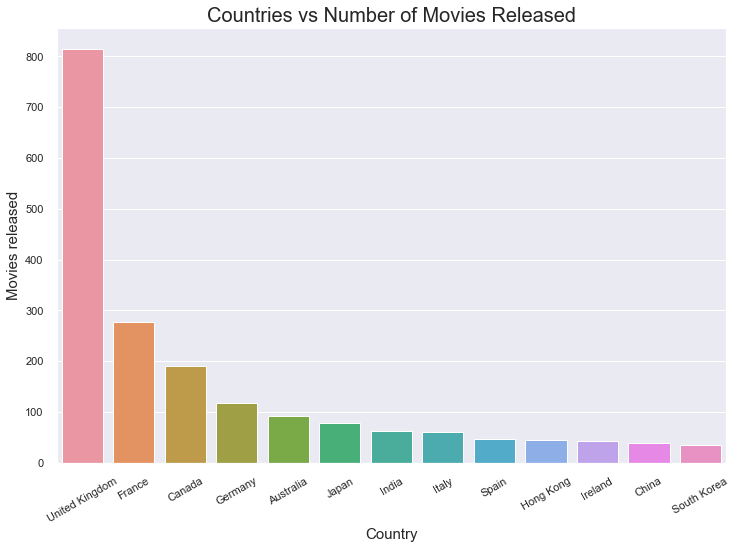

In [36]:
top_countries = df['country'].value_counts().head(14).reset_index().drop([0])

sns.barplot(x = top_countries.index, y = top_countries['country'])

plt.title('Countries vs Number of Movies Released', fontsize = 20)
plt.xlabel('Country', fontsize = 15)
plt.ylabel('Movies released', fontsize = 15)

plt.xticks(list(range(13)), top_countries['index'], rotation = 30)

plt.show()

This bar graph shows number of foreign movies released in US by the country each movie is from. The visualization shows that foreign movie market is dominated by movies from the West (UK, France, Canada, etc). For the record, Japan, India, and Honkong movies were in the top 10, but the number was vastly small compared to the number of movies from UK or France.

### Movie Directors - 
Highest Number of Movies Directed vs Highest Average Profit, and more

In [28]:
# some of the directors' names were recorded as 'Directors' (error), so 
# remove it from the dataset
df = df.drop(index = df[df['director'] == 'Directors'].index)

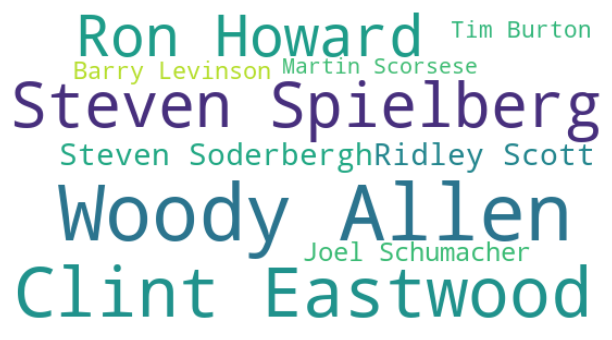

In [29]:
words = dict()
experience = df.groupby(['director']).size().sort_values(ascending=False).reset_index()
experience.columns = ['director', "frequency"]
for i in range(10):
    words[experience['director'][i]] = experience["frequency"][i]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [30]:
df['net'] = df['gross'] - df['budget']

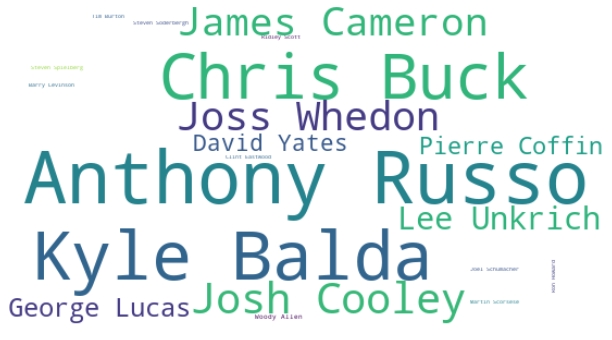

In [31]:
experiences = df.groupby(['director']).net.mean().sort_values(ascending=False).head(10).reset_index()
experiences.columns = ['director', 'net']
for i in range(10):
    words[experiences['director'][i]] = experiences["net"][i]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

It appears that the top directors with the most experiences of directing movies are not the ones who made movies with the most profit. While at it, lets compare the average net profit of the movies the top directors made (and compare them with the average).

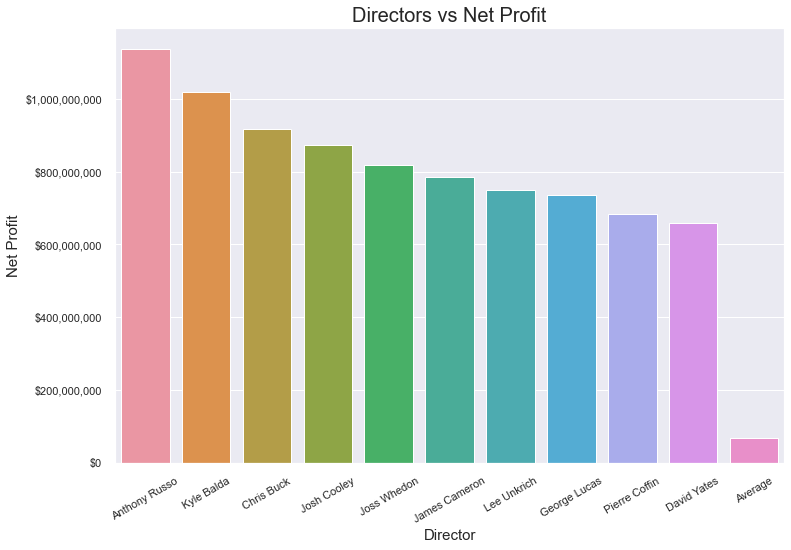

In [32]:
#Top 10 Directors with the most average net profit from movies they made including the average
experiences.loc[10] = ['Average', df['net'].mean()]

ax = sns.barplot(x = experiences['director'], y = experiences['net'])

plt.title('Directors vs Net Profit', fontsize = 20)
plt.xlabel('Director', fontsize = 15)
plt.ylabel('Net Profit', fontsize = 15)

plt.xticks(list(range(11)), experiences['director'], rotation = 30)
ticks = ax.get_yticks()
ylabel = ['$' + '{:,.0f}'.format(x) for x in ticks]
ax.set_yticklabels(ylabel)

plt.show()

Next, lets see if the main actor of a movie affects the success of a movie.

### Main Actors

In [33]:
# # Top 15 main actors who had the highest average net profit in the movies they were in as main actor
# actor = df.groupby(['star']).net.mean().sort_values(ascending=False).head(15).reset_index()
# actor.columns = ['actor', 'net']

# # Average profit of the movies with top 15 actors
# actor['net'].mean()

# # Average profit of all movies
# df['net'].mean()

# # Adding average data points 
# actor.loc[15] = ['Average (Top 15 Actors)', actor['net'].mean()]
# actor.loc[16] = ['Average (Of All Movies)', df['net'].mean()]
# # Bar chart visualizing the numbers
# ax = sns.barplot(x = actor['net'], y = actor['actor'])

# plt.title('Actor vs Net Profit', fontsize = 20)
# plt.xlabel('Net Profit', fontsize = 15)
# plt.ylabel('Actor', fontsize = 15)

# plt.yticks(list(range(17)), actor['actor'], rotation = 0)
# ticks = ax.get_xticks()
# xlabel = ['$' + '{:,.0f}'.format(x) for x in ticks]
# ax.set_xticklabels(xlabel)

# plt.show()

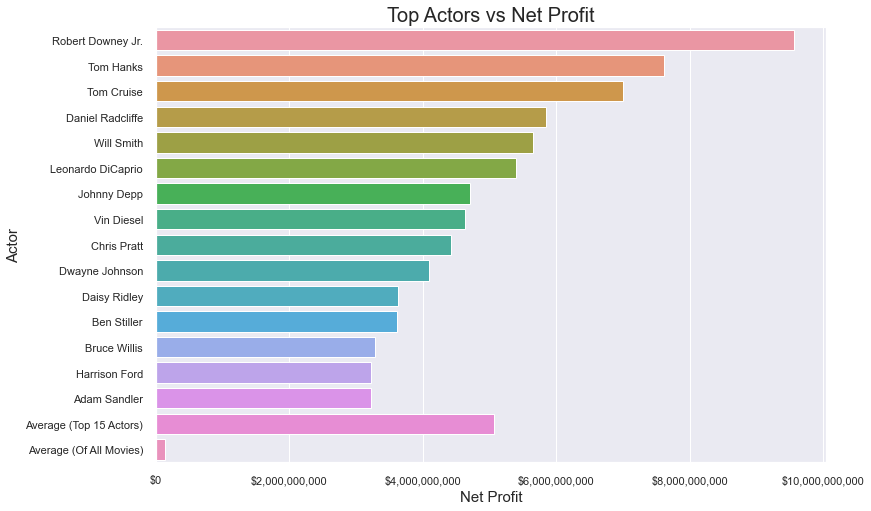

In [34]:
df[df['star'] == 'Donald Glover']
# Donald Glover was the main (voice) actor for The Lion King, just one movie.
# It appears that comparing Actor and average net profit of movies they were in isn't a good 
# comparison for the question.

# So, lets compare overall sum of net profit (of the movies they were in)
# Top 15 main actors - highest sum of net profit in the movies they were in as main actor
actor = df.groupby(['star']).net.sum().sort_values(ascending=False).head(15).reset_index()
actor.columns = ['actor', 'net']

# profit of the movies with top 15 actors
actor['net'].mean()

# Average sum of profit of all actors
df.groupby(['star']).net.sum().sort_values(ascending=False).reset_index()['net'].mean()

# Adding average data points 
actor.loc[15] = ['Average (Top 15 Actors)', actor['net'].mean()]
actor.loc[16] = ['Average (Of All Movies)', df.groupby(['star']).net.sum().sort_values(ascending=False).reset_index()['net'].mean()]
# Bar chart visualizing the numbers
ax = sns.barplot(x = actor['net'], y = actor['actor'])

plt.title('Top Actors vs Net Profit', fontsize = 20)
plt.xlabel('Net Profit', fontsize = 15)
plt.ylabel('Actor', fontsize = 15)

plt.yticks(list(range(17)), actor['actor'], rotation = 0)
ticks = ax.get_xticks()
xlabel = ['$' + '{:,.0f}'.format(x) for x in ticks]
ax.set_xticklabels(xlabel)

plt.show()

The graph above shows that certain (famous) actors can generate more profit for the movie they are in